In [1]:
import geopandas as gpd
import pandas as pd
import os
import json
import pylab as pl
import StringIO
import requests
import zipfile
import urllib2
import numpy as np
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DFDATA = os.getenv('DFDATA')
PUI2016 = os.getenv('PUI2016')
PUIDATA = os.getenv('PUIDATA')

In [3]:
s = json.load(open(PUI2016 + '/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Compare the energy consumed by a building to the number of units in the building

In [4]:
#data on energy consumption
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD"
"curl -o " + PUI2016 + "/energy.csv " + url
#url = str("https://data.cityofnewyork.us/resource/rgfe-8y2z.csv")
energy = pd.DataFrame.from_csv(url) 
energy.head()
#energy.columns

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [5]:
r = requests.get("http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip") 
z = zipfile.ZipFile(StringIO.StringIO(r.content))
p = z.extractall(PUIDATA)
units = gpd.read_file(PUIDATA + "/" + "MNMapPLUTO.shp")

In [6]:
units.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2010064090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1ff370a210>]], dtype=object)

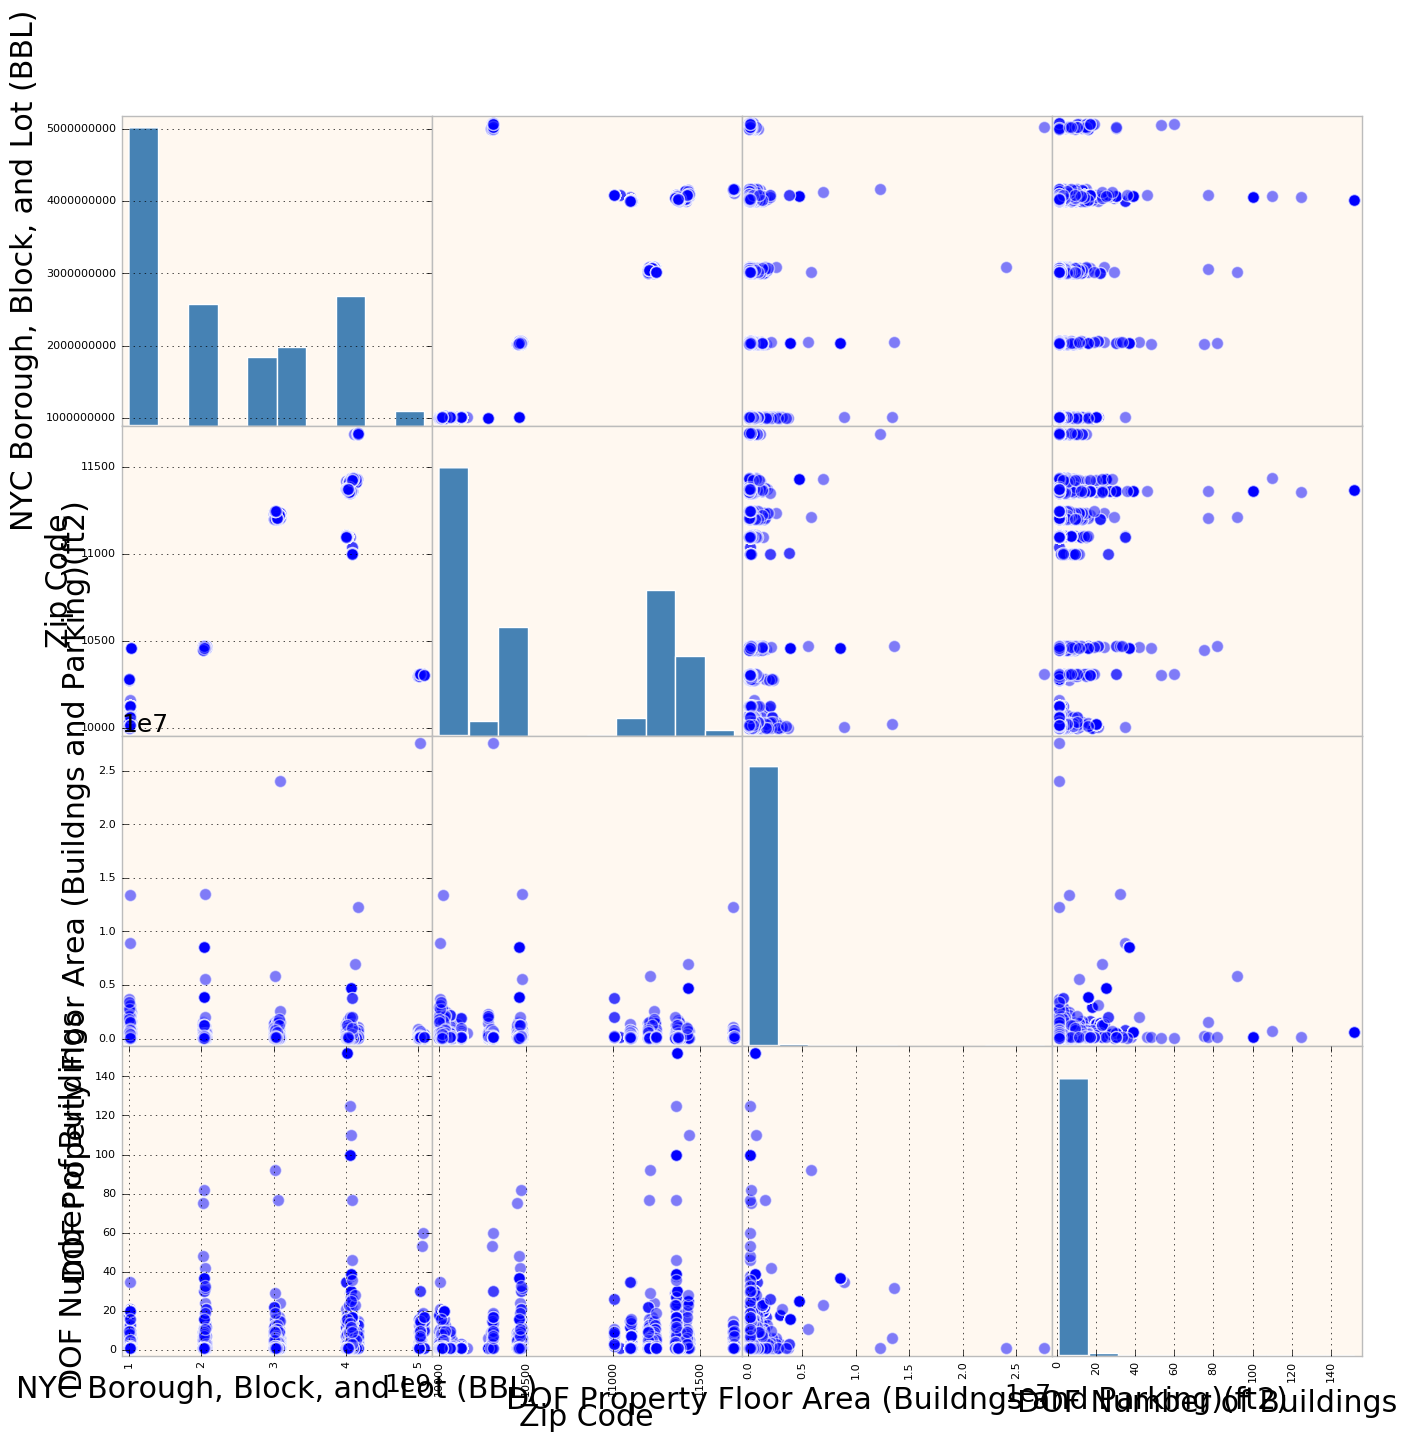

In [7]:
#scatter matrix shows that many columns don't have float values, or values that can convert to 
#float
scatter_matrix (energy, s=300, figsize=(16, 16))

### clean the energy dataset so that all values in the energy consumption column can be converted to float

In [8]:
#columns needed
#'NYC Borough, Block, and Lot (BBL)'
#'Site EUI(kBtu/ft2)'
#'Reported Property Floor Area (Building(s)) (ft²)'
energy2 = energy.drop(['Co-reported BBL Status', 'BBLs Co-reported', 'Reported NYC Building Identificaiton Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)', 'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], 1)

In [9]:
energy2.head()
len(energy2)

16170

In [10]:
def canconvert(mydata):
    try:
        float(mydata)
        return True
    except ValueError:
        return False

indx = (np.vectorize(canconvert)(energy2['Site EUI(kBtu/ft2)']))
print("True entries %d"%sum(indx))
energy2['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(energy2['Reported Property Floor Area (Building(s)) (ft²)']))
print("True entries %d"%sum(indx))
energy2['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')

indx3 = (np.vectorize(canconvert)(energy2['NYC Borough, Block, and Lot (BBL)']))
print("True entries %d"%sum(indx))
energy2['NYC Borough, Block, and Lot (BBL)'][~indx3] = float('NaN')

True entries 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True entries 15513
True entries 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#energy2['Site EUI(kBtu/ft2)'] = energy['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
#energy2['Reported Property Floor Area (Building(s)) (ft²)'] = energy['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)
#print(np.dtype(energy2['Site EUI(kBtu/ft2)']))

In [12]:
print(energy2['Site EUI(kBtu/ft2)'].astype(float))

Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14777      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), dtype: float64


In [13]:
units.BBL.astype(float)

0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

### merge the datasets on a common column name

In [14]:
units_reduced = pd.DataFrame()
units_reduced['BBL'] = units['BBL']
units_reduced['UnitsTotal'] = units['UnitsTotal']

In [15]:
energy2 = energy2.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'})
energy2.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000


In [16]:
#energy2['NYC Borough, Block, and Lot (BBL)'] = energy2['NYC Borough, Block, and Lot (BBL)'].astype(float)
energy2['Site EUI(kBtu/ft2)'] = energy2['Site EUI(kBtu/ft2)'].astype(float)
energy2['Reported Property Floor Area (Building(s)) (ft²)'] = energy2['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [17]:
print(np.dtype(energy2['Site EUI(kBtu/ft2)']))
print(np.dtype(energy2['Reported Property Floor Area (Building(s)) (ft²)']))

energy2['EnergyTotal'] = energy2['Site EUI(kBtu/ft2)'] * energy2['Reported Property Floor Area (Building(s)) (ft²)']

float64
float64


In [18]:
merged = pd.merge(energy2, units_reduced, on='BBL')
merged.head()
print(len(merged))
merged_dropped = merged.dropna()
print(len(merged_dropped))

6492
5069


In [19]:
#scatter_matrix (merged_dropped, s=30, figsize=(16, 16))

In [20]:
np.dtype(merged['UnitsTotal'])

dtype('int64')

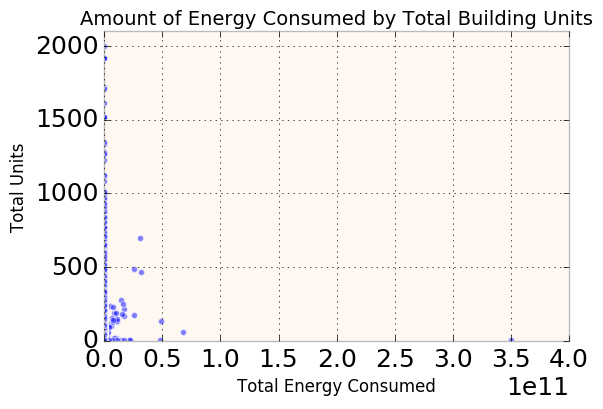

In [21]:
pl.scatter(x=merged['EnergyTotal'], y=merged['UnitsTotal'],alpha=0.5)
pl.axis([-5, 4e11, -5, 2100])
pl.title('Amount of Energy Consumed by Total Building Units', fontsize=14)
pl.xlabel('Total Energy Consumed', fontsize=12)
pl.ylabel('Total Units', fontsize=12)
pl.show()

### Caption for plot
This plot depicts the total amount of units as a function of total energy consumed.

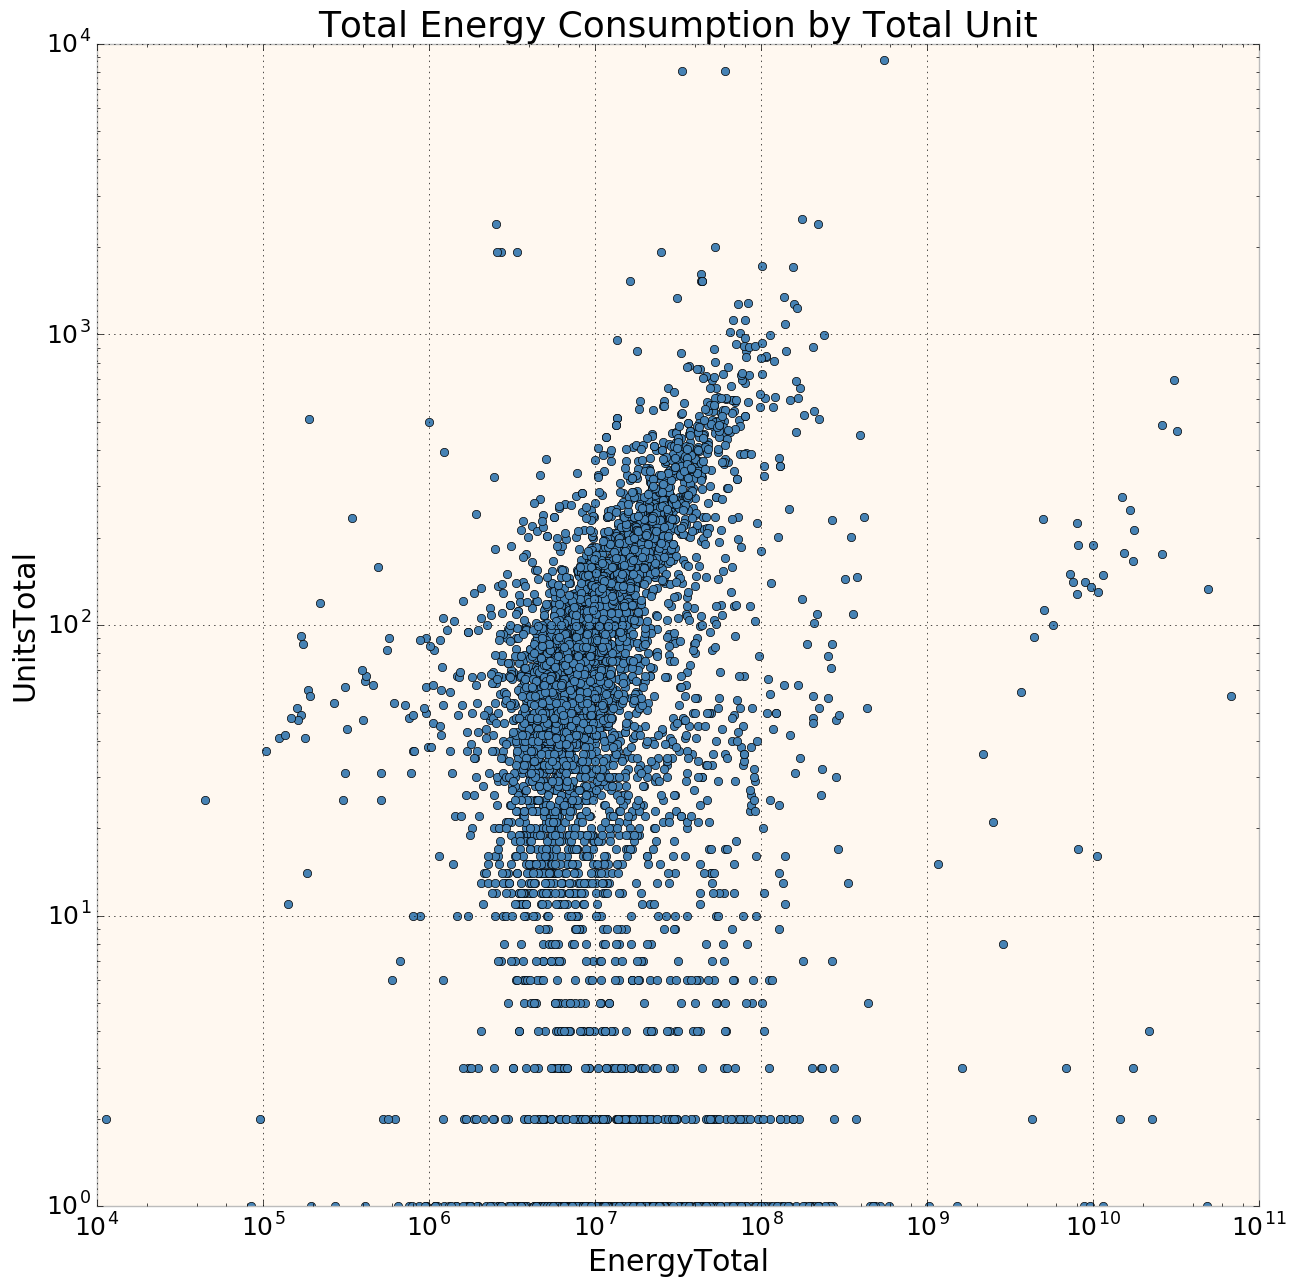

In [22]:
plt.figure(figsize=(15,15))
plt.loglog(merged['EnergyTotal'], merged['UnitsTotal'], 'o')
plt.xlim([10**4, 10**11])
plt.xlabel("EnergyTotal")
plt.ylabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

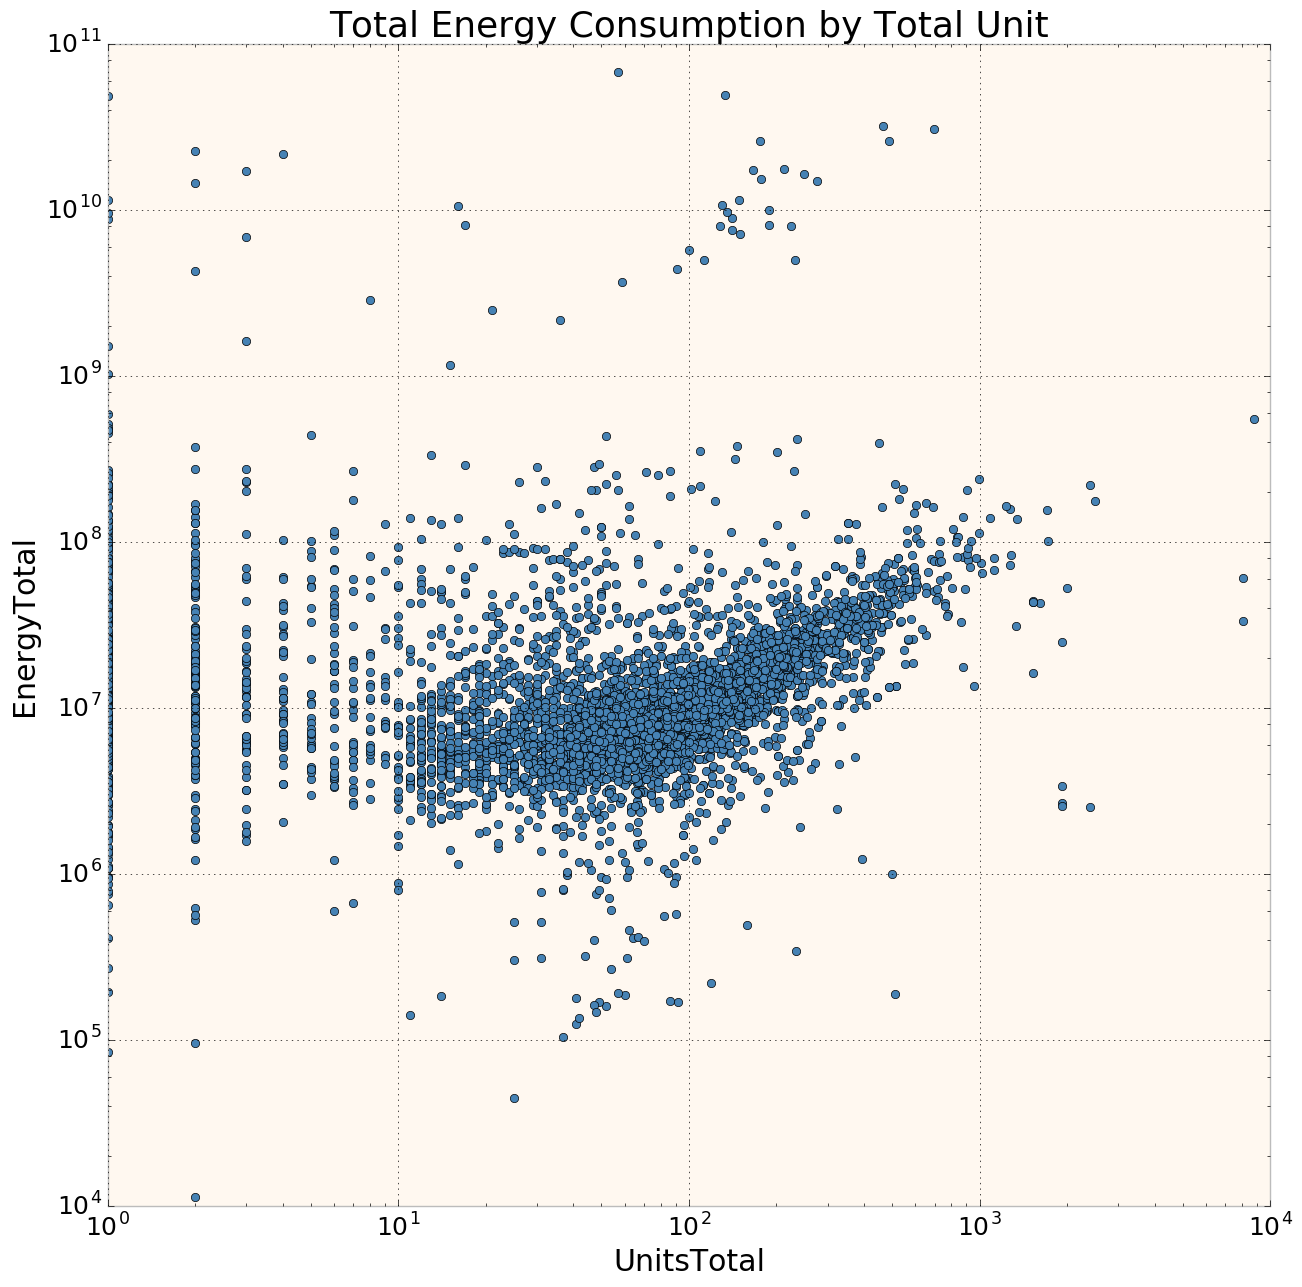

In [23]:
plt.figure(figsize=(15,15))
plt.loglog(merged['UnitsTotal'], merged['EnergyTotal'], 'o')
plt.ylim([10**4, 10**11])
plt.ylabel("EnergyTotal")
plt.xlabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

### create a line of best fit in log space

In [24]:
#fit a line units vs energy

#X = sm.add_constant(np.log10(merged['UnitsTotal']))
#y = np.log10(merged['EnergyTotal'])
#linmodel = sm.OLS(np.log10(merged['EnergyTotal']), X, missing='drop').fit() # ignores entires where x or y is NaN

In [45]:
X = sm.add_constant(np.log10(merged['UnitsTotal']))

In [48]:
print(type(X))
print(len(X))
X.head()

<class 'pandas.core.frame.DataFrame'>
6492


In [47]:
y = np.log10(merged['EnergyTotal'])

In [49]:
print(type(y))
print(len(y))
y.head()

<class 'pandas.core.series.Series'>
6492


0         NaN
1         NaN
2    7.616811
3         NaN
4         NaN
Name: EnergyTotal, dtype: float64

In [ ]:
#linmodel = sm.OLS(y, X, missing='drop').fit()

In [27]:
#fit a line energy vs units

#X_second = sm.add_constant(np.log10(merged['EnergyTotal']))
#y_second = np.log10(merged['UnitsTotal'])
#linmodel_second = sm.OLS(y_second, X_second, missing='drop').fit()

### fit a second degree curve to the datasets: ax^2+bx+c

In [30]:
#from federica's notebook:

#np.polyfit(x, y, 2)

#statsmodels.formula.api
#formula = 'y ~ 1 + x + I(x ^ 2.0)'

#which fit summary is better? the linear or the exponentiated?
#could you do a likelihood ratio?

## extra credit

In [31]:
#use wls weighted square fit instead of ordinary least squares
#give weights to the points
#estimate the errors

#create a function by hand that minimizes the residuals